In [486]:
# !lsof /dev/nvidia* | awk '{print $2}' | xargs -I {} kill {}

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Albly/Sparce_image_reconstruction/blob/master/notebooks/learn_lista.ipynb)

# Imports

In [ ]:
from IPython import get_ipython
import os 
import sys
from pathlib import Path

%load_ext autoreload
%autoreload 2

# check if we use colab or local machine
if 'google.colab' in str(get_ipython()):
    IS_COLAB = True
    print('Running on colab')
else:
    IS_COLAB = False
    print('Running on local machine')

if IS_COLAB:
    git_root = !git rev-parse --show-toplevel
    already_in_repo = os.path.exists(git_root[0])

    if not already_in_repo:
        !git clone https://github.com/Albly/Sparce_image_reconstruction $repo_dir

    sys.path.append('Sparce_image_reconstruction')

else:
    os.chdir(Path().absolute().parent)

In [19]:
%pylab inline

# external libraries
import torch
import yaml
from pathlib import Path
import os
import sys

# my scripts
%load_ext autoreload
%autoreload 2 # Reload all modules (except those excluded by %aimport) every time before executing the Python code typed
import plots
import system as syst
import qammod as qmd
import papreduce as prd
import ccdf as ccdf
import file as f

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
# Detect if we are in Google Colaboratory
try:
    import google.colab
    IN_COLAB = True
    print('You are going to use GOOGLE COLAB')
except ImportError:
    IN_COLAB = False
    print('You are going to use LOCAL DEVICE')

# Add path for scripts and files directory
if IN_COLAB:
    google.colab.drive.mount("/content/drive")
    AUX_DATA_ROOT = Path("/content/drive/My Drive/PAPR reduction/Code")
    assert AUX_DATA_ROOT.is_dir(), "Have you forgot to 'Add a shortcut to Drive'?"
    sys.path.append(str(AUX_DATA_ROOT))
else:
    AUX_DATA_ROOT = ''
    
CFG_PATH = os.path.join(AUX_DATA_ROOT, 'config.yaml')
      
if torch.cuda.is_available():
    device=torch.device('cuda')
    print('You are going to use CUDA')
else:
    device=torch.device('cpu')
    print('You are going to use CPU')

You are going to use LOCAL DEVICE
You are going to use CUDA


# Load system's configuration

In [21]:
with open('config.yaml','r') as file:
    cfg = yaml.load(file, Loader=yaml.FullLoader)
    print('Config has been readed successfully')

Fs = cfg['Fs']
N_UE = cfg['N_UE']
P_UE_max_min = cfg['P_UE_max_min']
P_TX = cfg['P_TX']
N_RB = cfg['N_RB']
N_fft = cfg['N_fft']
N_zero = cfg['N_zero']
N_used = cfg['N_used']

EVM_QPSK = cfg['EVM_QPSK']
EVM_QAM16 = cfg['EVM_QAM16']
EVM_QAM64 = cfg['EVM_QAM64']
EVM_QAM256 = cfg['EVM_QAM256']
# EVM_QAM1024 = cfg['EVM_QAM1024']

M = cfg['M']
N_SC_RB = cfg['N_SC_RB']

# load complex and decimal modulation constellations
constellations = qmd.load_constellations(config=cfg,device=device,info=True)

# load Fourier matrix
S_sc = prd.gen_fourier_matrix(config=cfg,device=device)

# PAPR range for CCDF
PAPR_RANGE = np.arange(0,12.25,step=0.25)

# zero shift to center spectrum
ZERO_SHIFT = N_zero//2

Config has been readed successfully
The following constelletions have been loaded: ['QPSK', 'QAM16', 'QAM64', 'QAM256']


In [22]:
S_sc.shape

torch.Size([1024, 1024])

In [ ]:
scipy

# Test cases

### QPSK EVM must be: $ 20 \log_{10}{(EVM_{QPSK})} = 20 \log_{10}{(17.5)} ~= -15.14 dB$

### QAM64 EVM must be: $ 20 \log_{10}{(EVM_{QAM64})} = 20 \log_{10}{(8)} ~= -21.93 dB$

In [4]:
print(20*log10(17.5/100))
print(20*log10(8/100))

-15.139239026274112
-21.93820026016113


In [5]:
# The 1st test case
PTX_allocation = np.array([100])
MOD_allocation,EVM_allocation = ['QAM64'],np.array([8])
ANL_allocation_P,ANL_allocation_A = syst.get_ANL_allocation(EVM_allocation,PTX_allocation,info=True)
ANL_allocation = ANL_allocation_P

print('The noise power difference ',10*log10(ANL_allocation[0]))
print('depends on power allocation',10*log10(1))

PTX_allocation = np.array([100])
MOD_allocation,EVM_allocation = ['qpsk'],np.array([17.5])
ANL_allocation_P,ANL_allocation_A = syst.get_ANL_allocation(EVM_allocation,PTX_allocation,info=True)
ANL_allocation = ANL_allocation_P

print('The noise power difference ',10*log10(ANL_allocation[0]))
print('depends on power allocation',10*log10(1))

Allowed noise level allocation (dB): [-21.93820026]
(%): [8.]

The noise power difference  -21.93820026016113
depends on power allocation 0.0
Allowed noise level allocation (dB): [-15.13923903]
(%): [17.5]

The noise power difference  -15.139239026274112
depends on power allocation 0.0


### For equal power allocation allowed EVM must degrade 2 times (3.01dB):
### EVM must be $-21.93 - 10 \log_{10}{(\frac{2}{1})} = -24.94dB$

In [6]:
# The 2nd test case
PTX_allocation = np.array([50,50])
MOD_allocation,EVM_allocation = ['QAM64','QAM64'],np.array([8,8])
ANL_allocation_P,ANL_allocation_A = syst.get_ANL_allocation(EVM_allocation,PTX_allocation,info=True)
ANL_allocation = ANL_allocation_P

print('The noise power difference ',10*log10(ANL_allocation[0])-10*log10(ANL_allocation[1]))
print('depends on power allocation',10*log10(PTX_allocation[0]/PTX_allocation[1]))

Allowed noise level allocation (dB): [-24.94850022 -24.94850022]
(%): [5.65685425 5.65685425]

The noise power difference  0.0
depends on power allocation 0.0


### For no-equal power allocation EVM must degrade by $10 \log_{10}{(P_i)} dB$

### EVM1: $-21.93 - 10 \log_{10}{(\frac{4}{3})} = -23.18dB$

### EVM2: $-21.93 - 10 \log_{10}{(\frac{4}{1})} = -27.95dB$

In [7]:
print(-21.93 - 10*log10(4/3))
print(-21.93 - 10*log10(4/1))

-23.179387366083
-27.950599913279625


In [8]:
# The 3rd test case
PTX_allocation = np.array([75,25])
MOD_allocation,EVM_allocation = ['QAM64','QAM64'],np.array([8,8])
ANL_allocation_P,ANL_allocation_A = syst.get_ANL_allocation(EVM_allocation,PTX_allocation,info=True)
ANL_allocation = ANL_allocation_P

print('The noise power difference ',10*log10(ANL_allocation[0])-10*log10(ANL_allocation[1]))
print('depends on power allocation',10*log10(PTX_allocation[0]/PTX_allocation[1]))

Allowed noise level allocation (dB): [-23.18758763 -27.95880017]
(%): [6.92820323 4.        ]

The noise power difference  4.7712125471966225
depends on power allocation 4.771212547196624


### EVM1: $-15.14 - 10 \log_{10}{(\frac{4}{3})} = -23.18dB$

### EVM2: $-21.93 - 10 \log_{10}{(\frac{4}{1})} = -27.95dB$

In [9]:
print(-15.14 - 10*log10(4/3))
print(-21.93 - 10*log10(4/1))

-16.389387366083
-27.950599913279625


In [10]:
# The 4th test case
PTX_allocation = np.array([75,25])
MOD_allocation,EVM_allocation = ['QPSK','QAM64'],np.array([17.5,8])
ANL_allocation_P,ANL_allocation_A = syst.get_ANL_allocation(EVM_allocation,PTX_allocation,info=True)
ANL_allocation = ANL_allocation_P

print('The noise power difference ',10*log10(ANL_allocation[0])-10*log10(ANL_allocation[1]))
print('depends on power allocation',10*log10(PTX_allocation[0]/PTX_allocation[1])+20*log10(EVM_allocation[0]/EVM_allocation[1]))

Allowed noise level allocation (dB): [-16.38862639 -27.95880017]
(%): [15.15544457  4.        ]

The noise power difference  11.57017378108364
depends on power allocation 11.570173781083643


### EVM1: $-15.14 - 10 \log_{10}{(\frac{4}{1})} = -21.16dB$

### EVM2: $-21.93 - 10 \log_{10}{(\frac{4}{1})} = -27.95dB$

In [11]:
print(-15.14 - 10*log10(4/1))
print(-21.93 - 10*log10(4/1))

-21.160599913279626
-27.950599913279625


In [12]:
# The 5th test case
PTX_allocation = np.array([25,25,25,25])
MOD_allocation,EVM_allocation = ['QPSK','QPSK','QAM64','QAM64'],np.array([17.5,17.5,8,8])
ANL_allocation_P,ANL_allocation_A = syst.get_ANL_allocation(EVM_allocation,PTX_allocation,info=True)
ANL_allocation = ANL_allocation_P

# print('The noise power difference ',10*log10(ANL_allocation[0])-10*log10(ANL_allocation[1]))
# print('depends on power allocation',10*log10(PTX_allocation[0]/PTX_allocation[1])+20*log10(EVM_allocation[0]/EVM_allocation[1]))

Allowed noise level allocation (dB): [-21.15983894 -21.15983894 -27.95880017 -27.95880017]
(%): [8.75 8.75 4.   4.  ]



# Power allocation
# Modulation type allocation, EVM allocation
# Allowed noise level allocation(calculation)
# Resourse block allocation

In [13]:
# TX power allocation
PTX_allocation = syst.PTX_allocate(config=cfg,info=True)
# Modulation type and according EVM allocation
MOD_allocation,EVM_allocation = syst.MOD_allocate(config=cfg,info=True)

# PTX_allocation = np.array([90,8,2])
# MOD_allocation,EVM_allocation = ['QPSK','QAM64','QAM256'],np.array([17.5,8,3.5])

# PTX_allocation = np.array([90,10])
# MOD_allocation,EVM_allocation = ['QPSK','QAM256'],np.array([17.5,3.5])

# PTX_allocation = np.array([100])
# MOD_allocation,EVM_allocation = ['QAM64'],np.array([3.5])

ANL_allocation_P,ANL_allocation_A = syst.get_ANL_allocation(EVM_allocation,PTX_allocation,info=True)
ANL_allocation = ANL_allocation_P

RB_allocation = syst.RB_allocate(config=cfg,info=True)

UE power has been allocated - OK:
Max UE power can be:     98.039
Min UE power can be:      0.980
Sum UE power can be:    100.000
Current Ptx allocation: [23. 44. 33.]
Sum UE power is:        100.000

MODs have been allocated - OK:
Current MODs allocation: ['QAM16', 'QAM256', 'QAM16']
Current EVMs allocation: [12.5  3.5 12.5]

Allowed noise level allocation (dB): [-24.44452138 -32.68411235 -22.87666034]
(%): [5.9947894  2.32163735 7.18070331]

RBs have been allocated - OK:
Current RB allocation: [13 18 19]
Sum UE RB is: 50



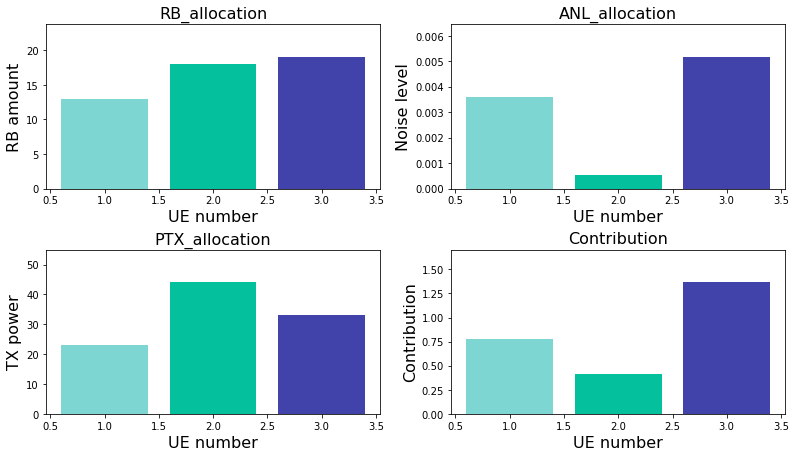

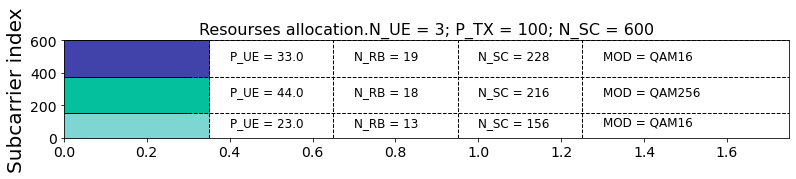

In [14]:
color_list = plots.plot_allocations(RB_allocation,PTX_allocation,ANL_allocation)
plots.plot_res_allocation(np.array(PTX_allocation),np.array(RB_allocation),MOD_allocation,color_list,cfg)

# OFDM signal generation

# Check PAPR

In [15]:
torch.cuda.ipc_collect()
torch.cuda.empty_cache()
S_t,S_f = syst.GEN_signal(MOD_allocation,PTX_allocation,RB_allocation,constellations,cfg,info=True)

PAPR,PAPR_mean0 = syst.get_signal_PAPR(S_t)
print('Initial mean PAPR is ',PAPR_mean0)
print(torch.mean(torch.abs(S_t.cpu())**2))
print(torch.mean(torch.abs(S_f.cpu())**2))
MOD_allocation

QAM1024 constellation has not been loaded since it is not defined in config file.
The signal has been generated:
Total power =              100.000
OFDM symbols:                 2500
IFFT length:                 1024
Mean power in freq dommain = 20.133
Mean power in time dommain = 20.133
Initial mean PAPR is  tensor(8.6701, device='cuda:0')
tensor(20.1328)
tensor(20.1328)


['QAM16', 'QAM256', 'QAM16']

In [16]:
S_t.shape

torch.Size([2500, 1024])

# Max and min PAPR OFDM symbol

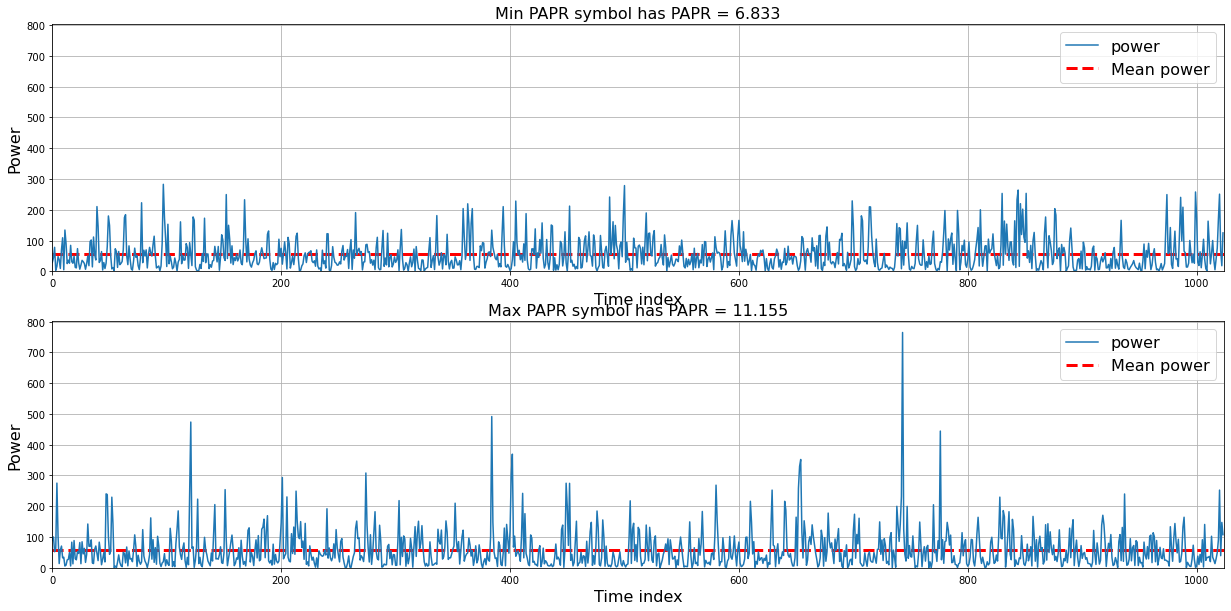

In [502]:
def find_max_min_papr_symbol(S_t,S_f,PAPR):
    min_papr,max_papr = {},{}
    min_papr['index'] = torch.nonzero(PAPR == torch.min(PAPR)).item()
    min_papr['value'] = PAPR[min_papr['index']].item()
    min_papr['symbol_t'] = S_t[min_papr['index'],:].cpu().squeeze()
    min_papr['symbol_f'] = S_f[min_papr['index'],:].cpu().squeeze()
    max_papr['index'] = torch.nonzero(PAPR == torch.max(PAPR))
    max_papr['value'] = PAPR[max_papr['index']].item()
    max_papr['symbol_t'] = S_t[max_papr['index'],:].cpu().squeeze()
    max_papr['symbol_f'] = S_f[max_papr['index'],:].cpu().squeeze()
    return min_papr,max_papr

min_papr,max_papr = find_max_min_papr_symbol(S_t,S_f,PAPR)

fontsize = 16
fig, (ax1, ax2) = plt.subplots(2, 1, sharey=False,figsize=(21,10))
s = torch.max(torch.max(torch.abs(max_papr['symbol_t'])**2),torch.max(torch.abs(max_papr['symbol_t'])**2))
ax1.set_xlim(0,1024)
ax1.set_ylim(0,1.05*s)
ax2.set_xlim(0,1024)
ax2.set_ylim(0,1.05*s)
ax1.set_ylabel('Power',fontsize=fontsize)
ax2.set_ylabel('Power',fontsize=fontsize)
ax1.set_xlabel('Time index',fontsize=fontsize)
ax2.set_xlabel('Time index',fontsize=fontsize)
ax1.plot(torch.abs(min_papr['symbol_t'])**2,label='power')
ax2.plot(torch.abs(max_papr['symbol_t'])**2,label='power')
ax1.set_title('Min PAPR symbol has PAPR = '+str(round(min_papr['value'],3)),fontsize=fontsize)
ax2.set_title('Max PAPR symbol has PAPR = '+str(round(max_papr['value'],3)),fontsize=fontsize)
ax1.grid()
ax2.grid()

ax1.hlines(torch.mean(torch.abs(min_papr['symbol_t'])**2),0,1024,'r','--',linewidth=3,label='Mean power')
ax2.hlines(torch.mean(torch.abs(max_papr['symbol_t'])**2),0,1024,'r','--',linewidth=3,label='Mean power')
ax1.legend(loc='upper right',fontsize=fontsize) 
ax2.legend(loc='upper right',fontsize=fontsize) 
plt.show()

# PAPR probability density function (PDF)

QAM1024 constellation has not been loaded since it is not defined in config file.
QAM1024 constellation has not been loaded since it is not defined in config file.
QAM1024 constellation has not been loaded since it is not defined in config file.
QAM1024 constellation has not been loaded since it is not defined in config file.
QAM1024 constellation has not been loaded since it is not defined in config file.
QAM1024 constellation has not been loaded since it is not defined in config file.
QAM1024 constellation has not been loaded since it is not defined in config file.
QAM1024 constellation has not been loaded since it is not defined in config file.
QAM1024 constellation has not been loaded since it is not defined in config file.
QAM1024 constellation has not been loaded since it is not defined in config file.


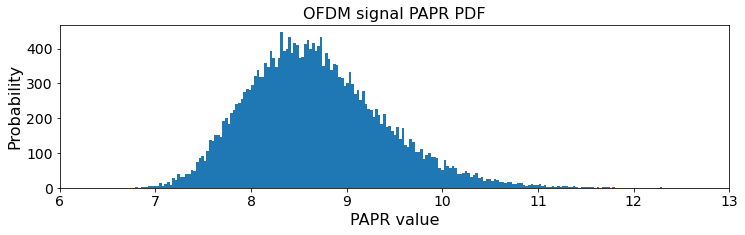

In [503]:
a = []
for i in range(10):
    torch.cuda.ipc_collect()
    torch.cuda.empty_cache()
    S_t,S_f = syst.GEN_signal(MOD_allocation,PTX_allocation,RB_allocation,constellations,cfg,info=False)

    PAPR,PAPR_mean0 = syst.get_signal_PAPR(S_t)
    a.append(np.copy(PAPR.cpu()))

bins = 200
plt.figure(figsize=(12,3))
plt.title('OFDM signal PAPR PDF',fontsize=16)
plt.xlabel('PAPR value',fontsize=16)
plt.ylabel('Probability',fontsize=16)

h = plt.hist(np.array(a).reshape(-1,1)[:], bins, label='Signal amplitude')
# plt.legend(loc='upper right', prop={'size': 14})
plt.xlim(6,13)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

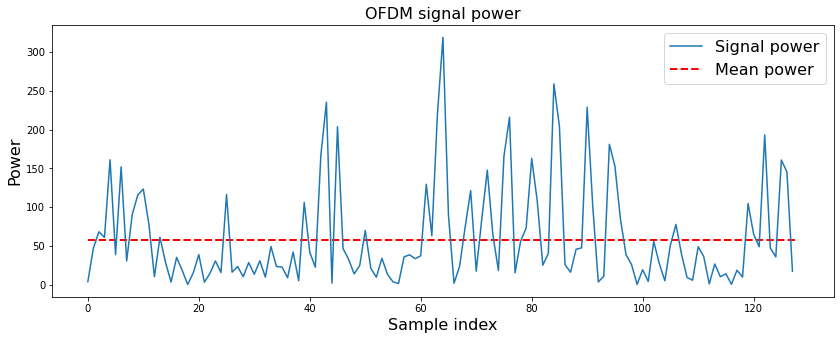

In [504]:
plt.figure(figsize=(14,5))

plt.title('OFDM signal power',fontsize=16)
plt.xlabel('Sample index',fontsize=16)
plt.ylabel('Power',fontsize=16)
plt.plot(abs(S_t[0,:128].cpu())**2,label='Signal power')
plt.hlines(mean(abs(np.array(S_t[0,:].cpu())**2)),0,128,'r','--',linewidth=2,label='Mean power')
plt.legend(fontsize=16)

In [505]:
peak_th = 7
i=0

G0_UE_idx = np.array([i])
G0_ANL = ANL_allocation[i]

# G0_UE_idx = np.array([0,1])
# G0_ANL = np.min(ANL_allocation)

# select subcarriers for PAPR reduction
# G0_SC = syst.GET_GROUP_SC(N_used=N_used,UE_indexes=G0_UE_idx,RB_allocation=torch.tensor(RB_allocation)) + ZERO_SHIFT
G0_SC = np.arange(N_used) + ZERO_SHIFT
# G0_SC = np.array([-100,-50,-10,0,10,50,100,400]) + ZERO_SHIFT

# generate group threshold
G0_group_th = G0_ANL

# choose peak selection thresold
# peak_th = 7
print("Consider as peaks signals exceeding (of mean power): ",10**(peak_th/10))
S_t_reduced = prd.PAPR_reduce(S_t,peak_th,G0_group_th,G0_SC,S_sc,cfg,info=True)

Consider as peaks signals exceeding (of mean power):  5.011872336272722
Pdata/Ptones before supression [-16.44 -16.52 -18.99 ... -17.37 -17.06 -13.53]
Pdata/Ptones after supression [-29.12 -29.12 -29.12 ... -29.12 -29.12 -29.12]


/home/stas/Test project/PAPR/papreduce.py:64: RuntimeWarning: divide by zero encountered in true_divide
  print("Pdata/Ptones after supression",np.round(-10*np.log10(np.array((power_data.cpu()/power_tones1))),2))


In [506]:
10*log10(ANL_allocation)

array([-29.11863911])

# th = 7

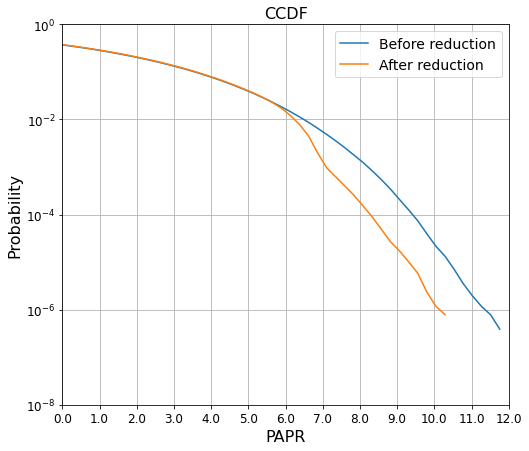

Mean PAPR before reduction: tensor(8.6742, device='cuda:0')
Mean PAPR after reduction: tensor(7.5199, device='cuda:0')
Mean PAPR has been reduced by:  tensor(1.1542, device='cuda:0') dB


In [507]:
LABELS = ["Before reduction","After reduction"]
CCDF1 = ccdf.get_CCDF(papr_range=PAPR_RANGE,S_t=S_t)
CCDF2 = ccdf.get_CCDF(papr_range=PAPR_RANGE,S_t=S_t_reduced)
CCDFs = [plots.filter_ccdf(CCDF1),plots.filter_ccdf(CCDF2)]

plots.plot_CCDF(CCDFs,LABELS,PAPR_RANGE,figsize=(8,7))

PAPR,PAPR_mean1 = syst.get_signal_PAPR(S_t_reduced)
print('Mean PAPR before reduction:',PAPR_mean0)
print('Mean PAPR after reduction:',PAPR_mean1)
print('Mean PAPR has been reduced by: ',PAPR_mean0-PAPR_mean1,'dB')

# th = 4

In [508]:
peak_th = 4
i=0

G0_UE_idx = np.array([i])
G0_ANL = ANL_allocation[i]

# G0_UE_idx = np.array([0,1])
# G0_ANL = np.min(ANL_allocation)

# select subcarriers for PAPR reduction
# G0_SC = syst.GET_GROUP_SC(N_used=N_used,UE_indexes=G0_UE_idx,RB_allocation=torch.tensor(RB_allocation)) + ZERO_SHIFT
G0_SC = np.arange(N_used) + ZERO_SHIFT
# G0_SC = np.array([-100,-50,-10,0,10,50,100,400]) + ZERO_SHIFT

# generate group threshold
G0_group_th = G0_ANL

# choose peak selection thresold
# peak_th = 7
print("Consider as peaks signals exceeding (of mean power): ",10**(peak_th/10))
S_t_reduced = prd.PAPR_reduce(S_t,peak_th,G0_group_th,G0_SC,S_sc,cfg,info=False)

Consider as peaks signals exceeding (of mean power):  2.51188643150958


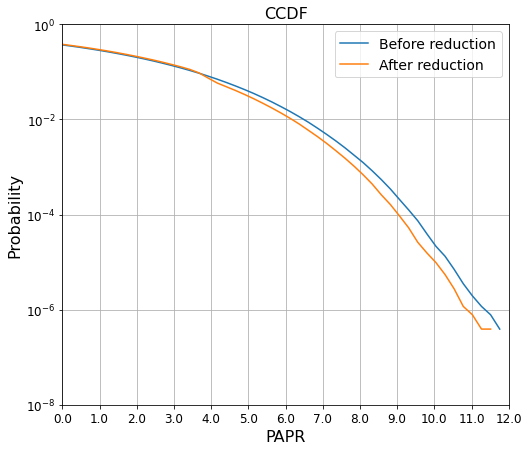

Mean PAPR before reduction: tensor(8.6742, device='cuda:0')
Mean PAPR after reduction: tensor(8.3085, device='cuda:0')
Mean PAPR has been reduced by:  tensor(0.3657, device='cuda:0') dB


In [509]:
LABELS = ["Before reduction","After reduction"]
CCDF1 = ccdf.get_CCDF(papr_range=PAPR_RANGE,S_t=S_t)
CCDF2 = ccdf.get_CCDF(papr_range=PAPR_RANGE,S_t=S_t_reduced)
CCDFs = [(CCDF1),(CCDF2)]

plots.plot_CCDF(CCDFs,LABELS,PAPR_RANGE,figsize=(8,7))

PAPR,PAPR_mean1 = syst.get_signal_PAPR(S_t_reduced)
print('Mean PAPR before reduction:',PAPR_mean0)
print('Mean PAPR after reduction:',PAPR_mean1)
print('Mean PAPR has been reduced by: ',PAPR_mean0-PAPR_mean1,'dB')

# th = 8

In [510]:
peak_th = 6.5
i=0

G0_UE_idx = np.array([i])
G0_ANL = ANL_allocation[i]

# G0_UE_idx = np.array([0,1])
# G0_ANL = np.min(ANL_allocation)

# select subcarriers for PAPR reduction
G0_SC = syst.GET_GROUP_SC(N_used=N_used,UE_indexes=G0_UE_idx,RB_allocation=torch.tensor(RB_allocation)) + ZERO_SHIFT
# G0_SC = np.arange(N_used) + ZERO_SHIFT
# G0_SC = np.array([-100,-50,-10,0,10,50,100,400]) + ZERO_SHIFT

# generate group threshold
G0_group_th = G0_ANL

# choose peak selection thresold
# peak_th = 7
print("Consider as peaks signals exceeding (of mean power): ",10**(peak_th/10))
# S_t_reduced = prd.PAPR_reduce(S_t,peak_th,G0_group_th,G0_SC,S_sc,cfg,info=False)
S_t_reduced = prd.PAPR_reduce(S_t,peak_th,G0_group_th,G0_SC,S_sc,cfg,info=False)

Consider as peaks signals exceeding (of mean power):  4.466835921509632


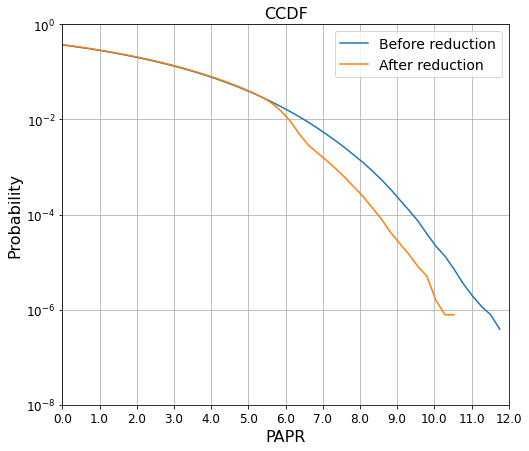

Mean PAPR before reduction: tensor(8.6742, device='cuda:0')
Mean PAPR after reduction: tensor(7.6869, device='cuda:0')
Mean PAPR has been reduced by:  tensor(0.9873, device='cuda:0') dB


In [511]:
LABELS = ["Before reduction","After reduction"]
CCDF1 = ccdf.get_CCDF(papr_range=PAPR_RANGE,S_t=S_t)
CCDF2 = ccdf.get_CCDF(papr_range=PAPR_RANGE,S_t=S_t_reduced)
CCDFs = [(CCDF1),(CCDF2)]

plots.plot_CCDF(CCDFs,LABELS,PAPR_RANGE,figsize=(8,7))

PAPR,PAPR_mean1 = syst.get_signal_PAPR(S_t_reduced)
print('Mean PAPR before reduction:',PAPR_mean0)
print('Mean PAPR after reduction:',PAPR_mean1)
print('Mean PAPR has been reduced by: ',PAPR_mean0-PAPR_mean1,'dB')

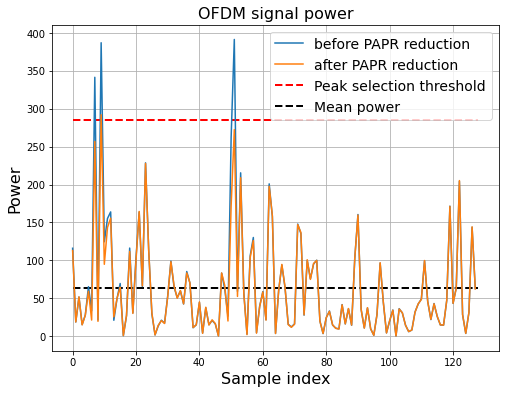

In [512]:
plt.figure(figsize=(8,6))
plt.title('OFDM signal power',fontsize=16)
plt.hlines(mean(np.abs(np.array(S_t[1,:128].cpu()))**2)*10**(peak_th/10),0,128,'r','--',linewidth=2,label='Peak selection threshold')
plt.hlines(mean(np.abs(np.array(S_t[1,:128].cpu()))**2),0,128,'k','--',linewidth=2,label='Mean power')

plot(abs(S_t[1,:128].cpu())**2,label='before PAPR reduction')
plot(abs(S_t_reduced[1,:128].cpu())**2,label='after PAPR reduction')
plt.legend(loc='upper right', prop={'size': 14})
plt.xlabel('Sample index',fontsize=16)
plt.ylabel('Power',fontsize=16)
plt.grid()

In [513]:
PD = torch.sum(torch.abs(S_t)**2,axis=1)/N_used
B = torch.sum(torch.abs(S_t-S_t_reduced)**2)/N_used
-10*torch.log10(PD.cpu()/(np.sum(np.abs(np.array((S_t-S_t_reduced).cpu()))**2,axis=1)/G0_SC.shape[0]))[:99]

tensor([-29.1186, -29.1186, -29.1186, -29.1186, -29.1186, -29.1186, -29.1186,
        -29.1186, -29.1186, -29.1186, -29.1186, -29.1186, -29.1186, -29.1186,
        -29.1186, -29.1186, -29.1186, -29.1186, -29.1186, -29.1186, -29.1186,
        -29.1186, -29.1186, -29.1186, -29.1186, -29.1186, -29.1186, -29.1186,
        -29.1186, -29.1186, -29.1186, -29.1186, -29.1186, -29.1186, -29.1186,
        -29.1186, -29.1186, -29.1186, -29.1186, -29.1186, -29.1186, -29.1186,
        -29.1186, -29.1186, -29.1186, -29.1186, -29.1186, -29.1186, -29.1186,
        -29.1186, -29.1186, -29.1186, -29.1186, -29.1186, -29.1186, -29.1186,
        -29.1186, -29.1186, -29.1186, -29.1186, -29.1186, -29.1186, -29.1186,
        -29.1186, -29.1186, -29.1186, -29.1186, -29.1186, -29.1186, -29.1186,
        -29.1186, -29.1186, -29.1186, -29.1186, -29.1186, -29.1186, -29.1186,
        -29.1186, -29.1186, -29.1186, -29.1186, -29.1186, -29.1186, -29.1186,
        -29.1186, -29.1186, -29.1186, -29.1186, -29.1186, -29.11

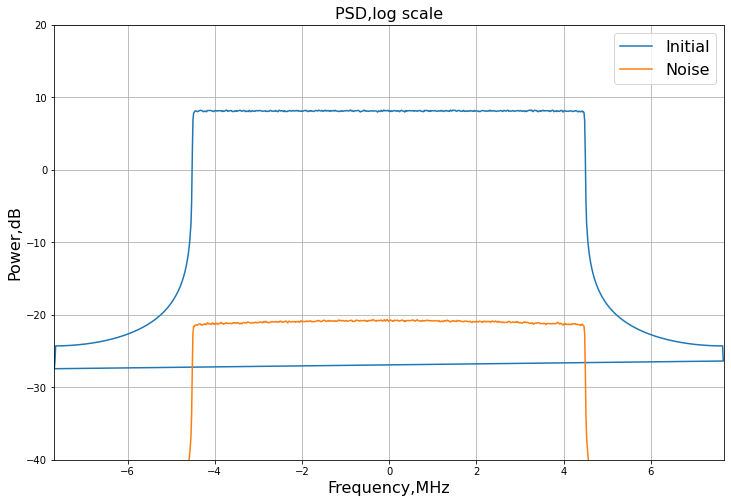

(['QAM64'], array([-29.11863911]))

In [514]:
SIGNALS = [S_t,S_t-S_t_reduced]
LABELS=['Initial','Noise']
TITLE='PSD,log scale'

PSD=plots.plot_spectrum(SIGNALS,LABELS,TITLE,Fs,cfg)
MOD_allocation,10*log10(ANL_allocation)

In [515]:
PSD

[array([[0.00180494, 0.00230669, 0.00372424, ..., 0.00372374, 0.00372345,
         0.00230608]], dtype=float32),
 array([[2.3564178e-06, 2.9841601e-06, 4.8085408e-06, ..., 4.8084898e-06,
         4.8081547e-06, 2.9837609e-06]], dtype=float32)]

Allowed EVM =  -29.118639112994487
Real    EVM =  -29.120402570879072


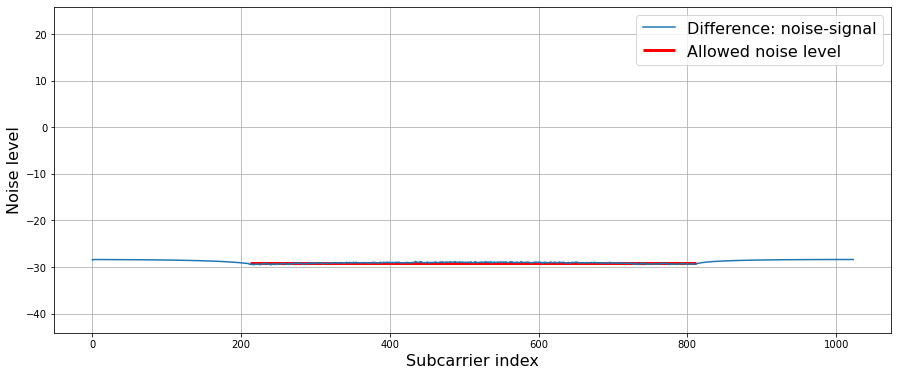

In [544]:
sc=np.arange(1024)
plt.figure(figsize=(15,6))
psd = -10*np.log10(PSD[0][0][sc])+10*np.log10(PSD[1][0][sc])
plt.plot(psd,label = 'Difference: noise-signal')
SC = syst.GET_UE_SC_idx(torch.tensor(RB_allocation))+ZERO_SHIFT
# plt.vlines(np.array([ZERO_SHIFT,ZERO_SHIFT+N_used]),-50,10,colors='k',linewidth=0.5)
for i in range(len(SC)-1):
    plt.hlines(10*np.log10(ANL_allocation[i]),SC[i],SC[i+1],colors='r',linewidth=3,label = 'Allowed noise level')
    
plt.ylabel('Noise level',fontsize=16)
plt.xlabel('Subcarrier index',fontsize=16)
plt.ylim(10*np.log10(ANL_allocation[i])-15,10*np.log10(ANL_allocation[i])+55)
plt.legend(fontsize=16)
plt.grid()

print('Allowed EVM = ',10*np.log10(ANL_allocation[i]))
print('Real    EVM = ',10*log10((torch.sum(torch.abs(S_t_reduced - S_t)**2)/torch.sum(torch.abs(S_t)**2)).cpu().item()))

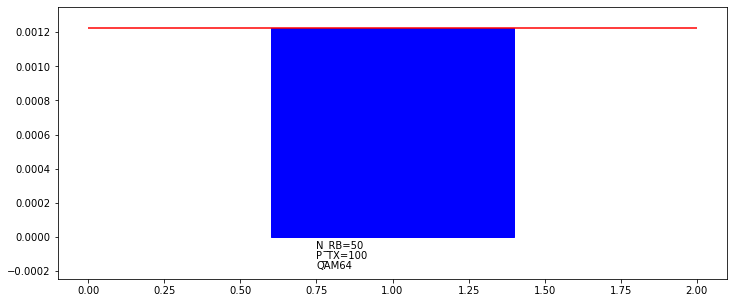

In [532]:
k=1
th = k*np.mean(ANL_allocation)

plt.figure(figsize=(12,5))
plt.hlines(th,0,N_UE+1,'r')
plt.ylim(-0.2*np.max(ANL_allocation),1.1*np.max(ANL_allocation))

bar = plt.bar(np.arange(N_UE)+1,ANL_allocation)

G1_UE_idx = np.nonzero(ANL_allocation > th)[0].astype(int)
G2_UE_idx = np.nonzero(ANL_allocation <= th)[0].astype(int)

# G1_UE_idx = np.array([0])
# G2_UE_idx = np.array([1])

for i in G1_UE_idx:
    bar[i].set_color('orange')
for i in G2_UE_idx:
    bar[i].set_color('blue')
    
for i in range(len(ANL_allocation)):
    plt.text(i+0.75,-0.05*np.max(ANL_allocation),'N_RB='+str(RB_allocation[i]))
    plt.text(i+0.75,-0.1*np.max(ANL_allocation),'P_TX='+str(PTX_allocation[i]))
    plt.text(i+0.75,-0.15*np.max(ANL_allocation),str(MOD_allocation[i]))

# PAPR reduction for several groups

In [518]:
G1_UE_idx_=np.array([0])#np.copy(G1_UE_idx[:])
G2_UE_idx_=np.array([1])#np.copy(G2_UE_idx[:])
G3_UE_idx_=np.array([2])#np.copy(G3_UE_idx[:])
th = 6.75
th = 7
peak_th = th
G1_group_th = np.min(ANL_allocation[G1_UE_idx_])
G1_SC = syst.GET_GROUP_SC(N_used=N_used,UE_indexes=G1_UE_idx_,RB_allocation=torch.tensor(RB_allocation)) + ZERO_SHIFT
S_t_reduced = prd.PAPR_reduce(S_t,peak_th,G1_group_th,G1_SC,S_sc,cfg,info=False)
# th = 6.5
# peak_th = th
# G2_group_th = np.min(ANL_allocation[G2_UE_idx_])
# G2_SC = syst.GET_GROUP_SC(N_used=N_used,UE_indexes=G2_UE_idx_,RB_allocation=torch.tensor(RB_allocation)) + ZERO_SHIFT
# S_t_reduced = prd.PAPR_reduce(S_t_reduced,peak_th,G2_group_th,G2_SC,S_sc,cfg,info=False)
# th = 150
# peak_th = th
# G3_group_th = np.min(ANL_allocation[G3_UE_idx_])
# G3_SC = syst.GET_GROUP_SC(N_used=N_used,UE_indexes=G3_UE_idx_,RB_allocation=torch.tensor(RB_allocation)) + ZERO_SHIFT
# S_t_reduced = prd.PAPR_reduce(S_t_reduced,peak_th,G3_group_th,G3_SC,S_sc,cfg,info=False)

PAPR,PAPR_mean1 = syst.get_signal_PAPR(S_t_reduced)
print('Mean PAPR before reduction:',PAPR_mean0)
print('Mean PAPR after reduction:',PAPR_mean1)
print('Mean PAPR has been reduced by: ',PAPR_mean0-PAPR_mean1,'dB')

Mean PAPR before reduction: tensor(8.6742, device='cuda:0')
Mean PAPR after reduction: tensor(7.5199, device='cuda:0')
Mean PAPR has been reduced by:  tensor(1.1542, device='cuda:0') dB


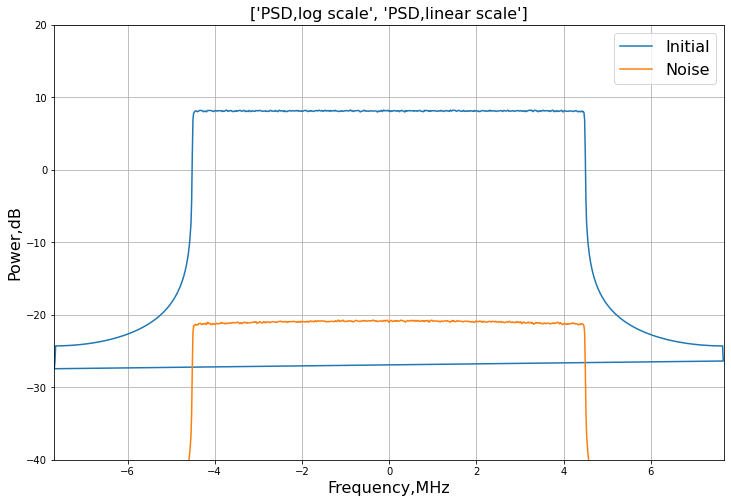

In [519]:
# SIGNALS = [S_t,S_t-S_t_reduced1,S_t-S_t_reduced2]
SIGNALS = [S_t,S_t-S_t_reduced]
LABELS=['Initial','Noise']
TITLES=['PSD,log scale','PSD,linear scale']

PSD = plots.plot_spectrum(SIGNALS,LABELS,TITLES,Fs,cfg)

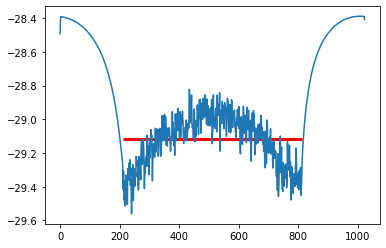

In [520]:
plot(-10*log10(PSD[0].T)+10*log10(PSD[1].T))
for i in range(len(SC)-1):
    plt.hlines(10*np.log10(ANL_allocation[i]),SC[i],SC[i+1],colors='r',linewidth=3)

In [521]:
EVM = 10*log10(torch.sum(torch.abs(S_t_reduced.cpu() - S_t.cpu())**2)/torch.sum(torch.abs(S_t.cpu())**2))
EVM

tensor(-29.1204)

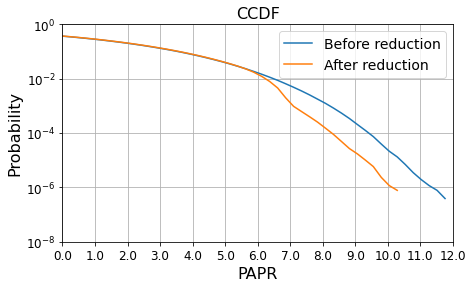

PAPR_mean before reduction tensor(8.6742, device='cuda:0')
PAPR_mean after reduction tensor(7.5199, device='cuda:0')
Delta =  tensor(1.1542, device='cuda:0')


In [522]:
LABELS = ["Before reduction","After reduction"]
CCDF1 = ccdf.get_CCDF(papr_range=PAPR_RANGE,S_t=S_t)
CCDF2 = ccdf.get_CCDF(papr_range=PAPR_RANGE,S_t=S_t_reduced)
CCDF = [CCDF1,CCDF2]

plots.plot_CCDF(CCDF,LABELS,PAPR_RANGE,figsize=(7,4))

PAPR,PAPR_mean2 = syst.get_signal_PAPR(S_t_reduced)
print('PAPR_mean before reduction',PAPR_mean0)
print('PAPR_mean after reduction',PAPR_mean2)
print('Delta = ',PAPR_mean0-PAPR_mean2)